# Pass Network (StatsBomb Data)

In [4]:
import math
import pandas as pd
from statsbombpy import sb
from mplsoccer import VerticalPitch

# First let's download our data
df = sb.events(match_id=3750235)

df[['x', 'y']] = df['location'].apply(pd.Series)
df[['end_x', 'end_y']] = df['pass_end_location'].apply(pd.Series)

df = df[df['team'] == 'Ajax']

In [6]:
#Retrieving Player Shirt Numbers

tactics = df[~df['tactics'].isnull()][['tactics', 'team']]

all_jersey_numbers = []
for y in tactics.to_dict(orient='records'):
    all_jersey_numbers.append(pd.DataFrame([{'player_id': x['player']['id'], 'jersey_number': x['jersey_number']} for x in y['tactics']['lineup']]))
    
jersey_numbers = pd.concat(all_jersey_numbers).drop_duplicates()

In [10]:
df.player.unique()

array([nan, 'Johan Cruyff', 'Piet Keizer', 'Arie Haan', 'Wim Suurbier',
       'Gerrie Mühren', 'Horst Blankenburg', 'Heinz Stuy', 'Sjaak Swart',
       'Ruud Krol', 'Johan Neeskens', 'Barry Hulshoff'], dtype=object)

In [14]:
# Make a new, single column for time and sort the events in chronological order
df["newsecond"] = 60 * df["minute"] + df["second"]

df.sort_values(by=['newsecond'])

# identify the passer and then the recipient, who'll be the playerId of the next action
df['passer'] = df['player_id']

df['recipient'] = df['passer'].shift(-1)

# filter for only passes and then successful passes
passes_df = df.loc[(df['type']=="Pass")]
passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")

completions = passes_df.loc[(passes_df['pass_outcome'] == "Successful")]

#find time of the team's first substitution and filter the df to only passes before that
#sub_df = df.loc[(df['type'] == "Substitution")]
#sub_df = df.loc[df['substitution_replacement'].isna() == True]
#first_sub = sub_df["newsecond"].min()

#if first_sub <= (60 * 45):
    #first_sub = 60 * 45

#completions = completions.loc[completions['newsecond'] < first_sub]

# Find Average Locations
average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean','count']})
average_locs_and_count.columns = ['x', 'y', 'count']

# find number of passes along each 'path' of passer to recipient
passes_between = completions.groupby(['passer', 'recipient']).id.count().reset_index()
passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
passes_between = passes_between.merge(
    average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end']
)

# set minimum threshold for pass arrows to be plotted. So this will only plot combos which occured at least 5 times.
passes_between = passes_between.loc[(passes_between['pass_count'] >= 4)]

/var/folders/dv/7l2p8f4j2gbcl552tflf3zw40000gn/T/ipykernel_5794/1408255225.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")


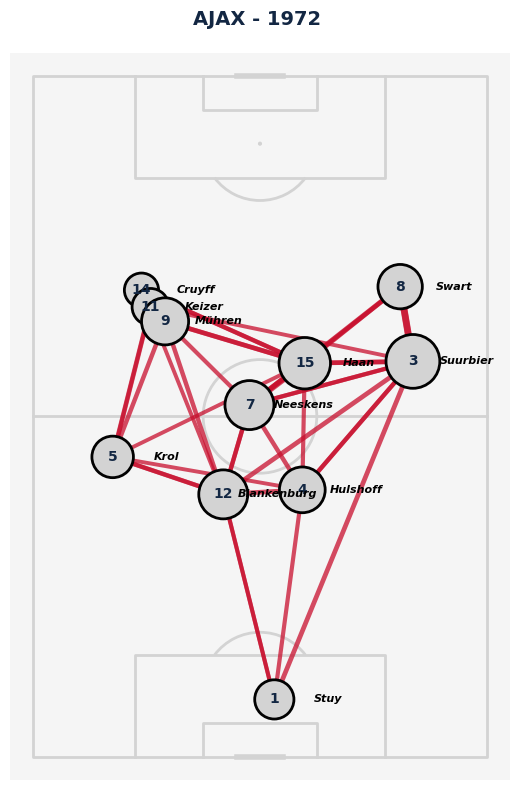

In [60]:
import math
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

# Improved pass line plotting function with a smoother arrow design
def pass_line_template(ax, x, y, end_x, end_y, line_color, alpha=0.8, width=3):
    ax.annotate(
        '',
        xy=(end_y, end_x),  # Correctly placed endpoint
        xytext=(y, x),      # Correctly placed start point
        zorder=1,
        arrowprops=dict(
            arrowstyle='-|>',
            linewidth=width,
            color=line_color,
            alpha=alpha,
            shrinkA=0,  # Ensures arrows fit better
            shrinkB=0
        )
    )

# Function to shrink the arrow based on distance
def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2, width=3, alpha=0.8):
    dist = math.hypot(end_x - x, end_y - y)
    angle = math.atan2(end_y - y, end_x - x)
    upd_x = x + (dist - dist_delta) * math.cos(angle)
    upd_y = y + (dist - dist_delta) * math.sin(angle)
    pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color, alpha=alpha, width=width)

# Create pitch and figure
pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#f5f5f5', line_color='#d3d3d3', line_zorder=1)
fig, ax = pitch.draw(figsize=(12, 8))

# Plot arrows for passes
for index, row in passes_between.iterrows():
    pass_line_template_shrink(
        ax,
        row['x'], row['y'],
        row['x_end'], row['y_end'],
        line_color='#c8102E',  # Improved to a vibrant red  #D2122E  
        width=2 + row['pass_count'] / passes_between['pass_count'].max() * 3,  # Dynamic width based on pass count
        alpha=0.75
    )

# Improved node plotting
node_sizes = average_locs_and_count['count'] / average_locs_and_count['count'].max() * 1500  # Scaled size
pitch.scatter(
    average_locs_and_count.x,
    average_locs_and_count.y,
    s=node_sizes,
    color='#d3d3d3',  # Neutral node color
    edgecolors="#010101",  # Strong contrast for edges
    linewidth=2,
    alpha=1,
    ax=ax,
    zorder=2
)

# Annotating nodes with jersey numbers and player names
for index, row in average_locs_and_count.iterrows():
    # Get the player's jersey number and name
    jersey_no = jersey_numbers[jersey_numbers['player_id'] == row.name]['jersey_number'].values[0]
    player_name = df[df['player_id'] == row.name]['player'].values[0]
    last_name = player_name.split()[-1]  # Extract the last name

    # Annotate the jersey number
    pitch.annotate(
        jersey_no,
        xy=(row.x, row.y),
        c='#132743',  # Dark text for visibility
        va='center',
        ha='center',
        size=10,
        fontweight='bold',
        ax=ax
    )

    # Annotate the player's name slightly below the node
    pitch.annotate(
        last_name,
        xy=(row.x, row.y + 9.5),  # Slightly offset below the node
        c='black',
        va='center',
        ha='center',
        size=8,
        fontstyle='italic',
        weight='bold',
        ax=ax
    )

# Adding a title for the plot
ax.set_title(
    "AJAX - 1972 ",
    fontsize=14,
    fontweight='bold',
    color='#132743',
    pad=20
)

plt.tight_layout()
plt.show()


# Pass Networks in a Grid

/var/folders/dv/7l2p8f4j2gbcl552tflf3zw40000gn/T/ipykernel_6815/903404202.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")
/var/folders/dv/7l2p8f4j2gbcl552tflf3zw40000gn/T/ipykernel_6815/903404202.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")
/var/folders/dv/7l2p8f4j2gbcl552tflf3zw40000gn/T/ipykernel_6815/903404202.py:57: SettingWithCopyWarning: 
A 

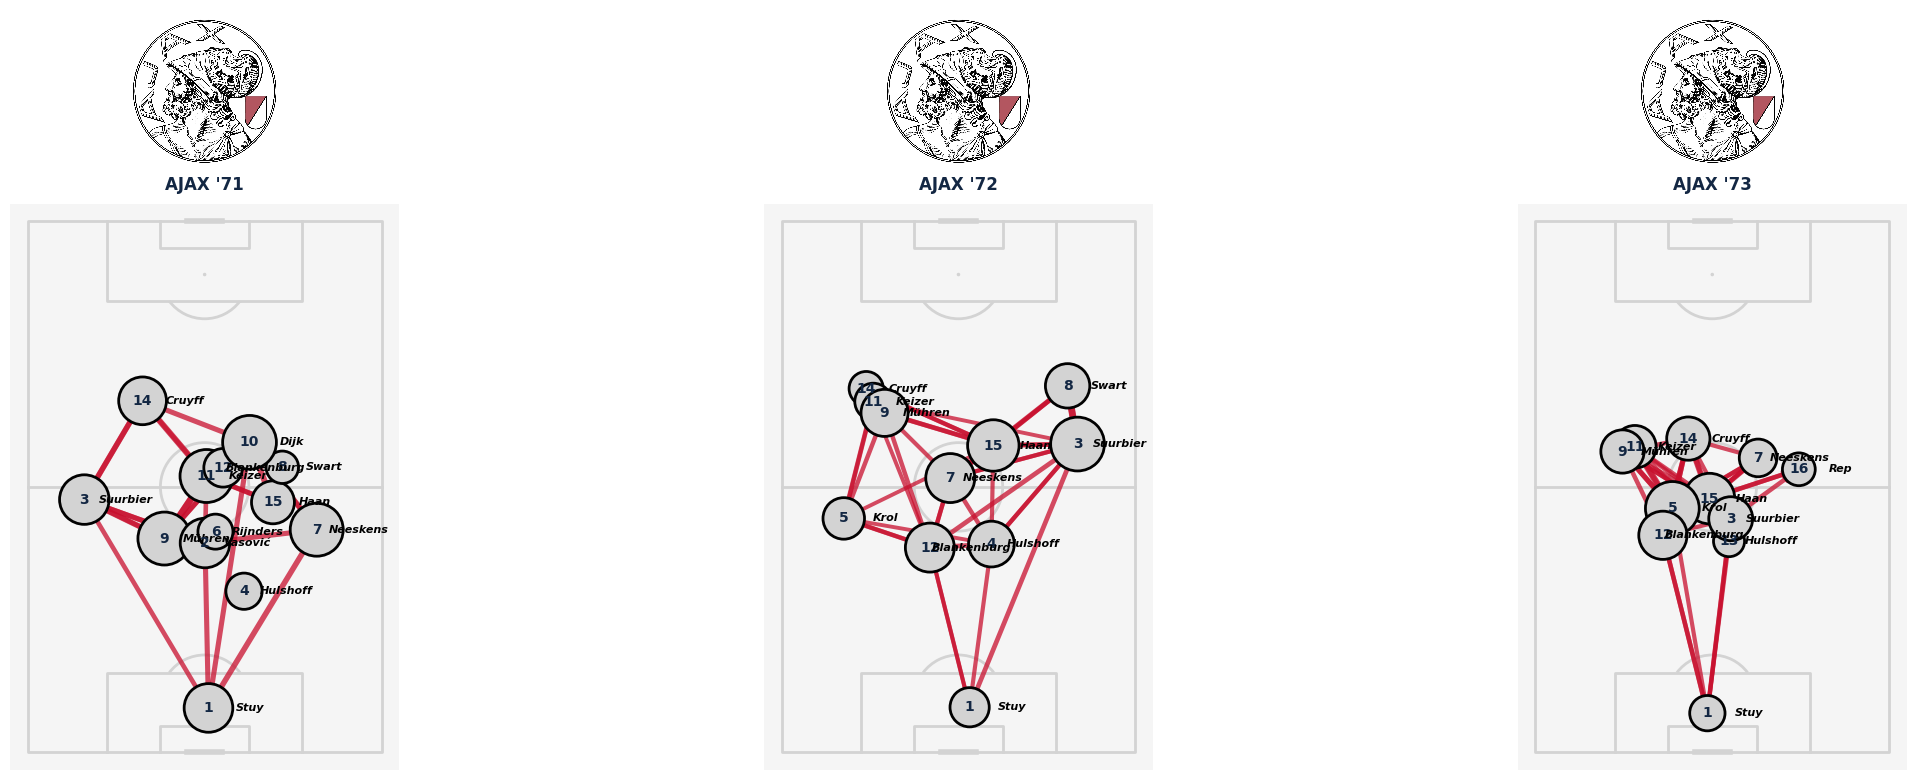

In [33]:
import math
import pandas as pd
from statsbombpy import sb
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Path to the Ajax logo (ensure the path is correct)
ajax_logo_path = '/Users/trymso/Desktop/ajax_logo.jpg' #download any picture to your working repository

# Match IDs and corresponding titles
match_ids = [3888711, 3750235, 3888706]
titles = ["AJAX '71", "AJAX '72", "AJAX '73"]  # Titles for each plot

# Function to add the logo above the plot
def add_logo(ax, logo_path, zoom=0.05):
    ax.add_artist(AnnotationBbox(OffsetImage(plt.imread(logo_path), zoom=zoom),
                                 (0.5, 1.2),  # Adjusted to place the logo slightly above the title
                                 xycoords='axes fraction', frameon=False))

# Create a figure with 3 subplots in a single row
fig, axs = plt.subplots(1, 3, figsize=(24, 8))  # 1 row, 3 columns for the grid

# Loop through each match ID and create a pass network
for i, match_id in enumerate(match_ids):
    # Load data
    df = sb.events(match_id=match_id)

    df[['x', 'y']] = df['location'].apply(pd.Series)
    df[['end_x', 'end_y']] = df['pass_end_location'].apply(pd.Series)

    df = df[df['team'] == 'Ajax']

    # Retrieving Player Shirt Numbers
    tactics = df[~df['tactics'].isnull()][['tactics', 'team']]

    all_jersey_numbers = []
    for y in tactics.to_dict(orient='records'):
        all_jersey_numbers.append(pd.DataFrame(
            [{'player_id': x['player']['id'], 'jersey_number': x['jersey_number']} for x in y['tactics']['lineup']]
        ))

    jersey_numbers = pd.concat(all_jersey_numbers).drop_duplicates()

    # Make a new, single column for time and sort the events in chronological order
    df["newsecond"] = 60 * df["minute"] + df["second"]

    df.sort_values(by=['newsecond'])

    # identify the passer and then the recipient, who'll be the playerId of the next action
    df['passer'] = df['player_id']

    df['recipient'] = df['passer'].shift(-1)

    # filter for only passes and then successful passes
    passes_df = df.loc[(df['type'] == "Pass")]
    passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")

    completions = passes_df.loc[(passes_df['pass_outcome'] == "Successful")]

    # Find Average Locations
    average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean', 'count']})
    average_locs_and_count.columns = ['x', 'y', 'count']

    # find number of passes along each 'path' of passer to recipient
    passes_between = completions.groupby(['passer', 'recipient']).id.count().reset_index()
    passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    passes_between = passes_between.merge(average_locs_and_count, left_on='passer', right_index=True)
    passes_between = passes_between.merge(
        average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end']
    )

    # set minimum threshold for pass arrows to be plotted. So this will only plot combos which occured at least 5 times.
    passes_between = passes_between.loc[(passes_between['pass_count'] >= 4)]

    # Improved pass line plotting function with a smoother arrow design
    def pass_line_template(ax, x, y, end_x, end_y, line_color, alpha=0.8, width=3):
        ax.annotate(
            '',
            xy=(end_y, end_x),  # Correctly placed endpoint
            xytext=(y, x),      # Correctly placed start point
            zorder=1,
            arrowprops=dict(
                arrowstyle='-|>',
                linewidth=width,
                color=line_color,
                alpha=alpha,
                shrinkA=0,  # Ensures arrows fit better
                shrinkB=0
            )
        )

    # Function to shrink the arrow based on distance
    def pass_line_template_shrink(ax, x, y, end_x, end_y, line_color, dist_delta=1.2, width=3, alpha=0.8):
        dist = math.hypot(end_x - x, end_y - y)
        angle = math.atan2(end_y - y, end_x - x)
        upd_x = x + (dist - dist_delta) * math.cos(angle)
        upd_y = y + (dist - dist_delta) * math.sin(angle)
        pass_line_template(ax, x, y, upd_x, upd_y, line_color=line_color, alpha=alpha, width=width)

    # Create pitch for the current subplot
    pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#f5f5f5', line_color='#d3d3d3', line_zorder=1)
    pitch.draw(ax=axs[i])

    # Plot arrows for passes
    for index, row in passes_between.iterrows():
        pass_line_template_shrink(
            axs[i],
            row['x'], row['y'],
            row['x_end'], row['y_end'],
            line_color='#c8102E',  # Improved to a vibrant red
            width=2 + row['pass_count'] / passes_between['pass_count'].max() * 3,  # Dynamic width based on pass count
            alpha=0.75
        )

    # Improved node plotting
    node_sizes = average_locs_and_count['count'] / average_locs_and_count['count'].max() * 1500  # Scaled size
    pitch.scatter(
        average_locs_and_count.x,
        average_locs_and_count.y,
        s=node_sizes,
        color='#d3d3d3',  # Neutral node color
        edgecolors="#010101",  # Strong contrast for edges
        linewidth=2,
        alpha=1,
        ax=axs[i],
        zorder=2
    )

    # Annotating nodes with jersey numbers and player names
    for index, row in average_locs_and_count.iterrows():
        # Get the player's jersey number and name
        jersey_no = jersey_numbers[jersey_numbers['player_id'] == row.name]['jersey_number'].values[0]
        player_name = df[df['player_id'] == row.name]['player'].values[0]
        last_name = player_name.split()[-1]  # Extract the last name

        # Annotate the jersey number
        pitch.annotate(
            jersey_no,
            xy=(row.x, row.y),
            c='#132743',  # Dark text for visibility
            va='center',
            ha='center',
            size=10,
            fontweight='bold',
            ax=axs[i]
        )

        # Annotate the player's name slightly below the node
        pitch.annotate(
            last_name,
            xy=(row.x, row.y + 9.5),  # Slightly offset below the node
            c='black',
            va='center',
            ha='center',
            size=8,
            fontstyle='italic',
            weight='bold',
            ax=axs[i]
        )

    # Adding the custom title
    axs[i].set_title(
        titles[i],  # Custom title
        fontsize=12,  # Slightly smaller font size for better alignment
        fontweight='bold',
        color='#132743',
        pad=10  # Increase padding to avoid overlap with the logo
    )

    # Adding the Ajax logo
    add_logo(axs[i], ajax_logo_path)

plt.tight_layout()
plt.show()


In [42]:
fig.savefig('/Users/Trymso/Desktop/Ajax.png', dpi=300, bbox_inches='tight')

# Player Pass Connections for Johan Cruyff

In [3]:
import math
import pandas as pd
from statsbombpy import sb
from mplsoccer import VerticalPitch

df = sb.events(match_id=3750235)

df[['x', 'y']] = df['location'].apply(pd.Series)
df[['end_x', 'end_y']] = df['pass_end_location'].apply(pd.Series)

df = df[df['team'] == 'Ajax']

In [13]:
#Retrieving Player Shirt Numbers

tactics = df[~df['tactics'].isnull()][['tactics', 'team']]

all_jersey_numbers = []
for y in tactics.to_dict(orient='records'):
    all_jersey_numbers.append(pd.DataFrame([{'player_id': x['player']['id'], 'jersey_number': x['jersey_number']} for x in y['tactics']['lineup']]))
    
jersey_numbers = pd.concat(all_jersey_numbers).drop_duplicates()

In [5]:
# Drop duplicates based on 'player' and 'player_id' and sort the data
unique_players = df[['player', 'player_id']].drop_duplicates().sort_values(by=['player', 'player_id'])

# Display the sorted unique players
display(unique_players)


,player,player_id
8,Arie Haan,39719.0
48,Barry Hulshoff,39726.0
11,Gerrie Mühren,39724.0
23,Heinz Stuy,39728.0
19,Horst Blankenburg,39729.0
6,Johan Cruyff,39713.0
44,Johan Neeskens,39721.0
7,Piet Keizer,39716.0
33,Ruud Krol,39720.0
31,Sjaak Swart,39723.0


/var/folders/dv/7l2p8f4j2gbcl552tflf3zw40000gn/T/ipykernel_8546/2166755021.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")


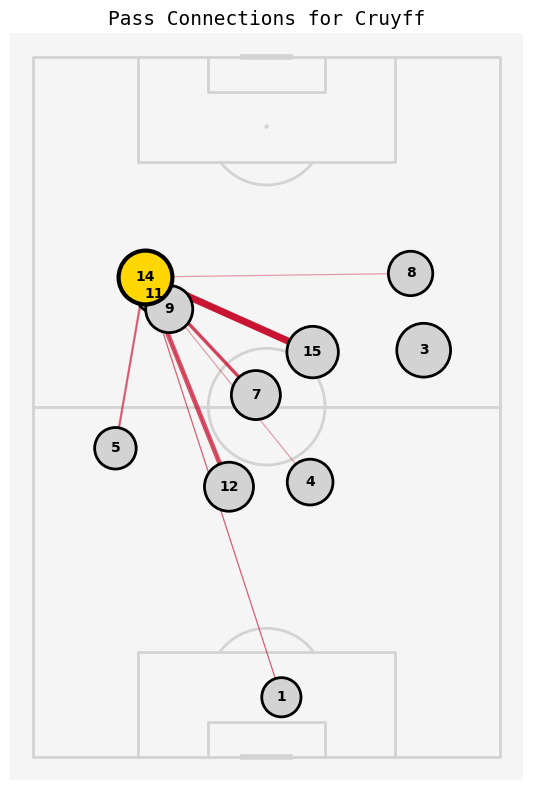

In [17]:
import math
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

# Johan Cruyff's player ID (make sure this is correct)
cruyff_id = 39713  # Set as the player ID directly, not a DataFrame

# Identify the passer and recipient for passes
df['passer'] = df['player_id']
df['recipient'] = df['passer'].shift(-1)  # The recipient is the next player's ID in sequence

# Filter for only passes and fill missing pass outcomes as "Successful"
passes_df = df.loc[(df['type'] == "Pass")]
passes_df['pass_outcome'] = passes_df['pass_outcome'].fillna("Successful")

# Filter for only successful passes
completions = passes_df.loc[passes_df['pass_outcome'] == "Successful"]

# Find Average Locations
average_locs_and_count = completions.groupby('passer').agg({'x': ['mean'], 'y': ['mean','count']})
average_locs_and_count.columns = ['x', 'y', 'count']

# Filter for passes involving Johan Cruyff
cruyff_completions = completions[
    (completions['passer'] == cruyff_id) | (completions['recipient'] == cruyff_id)
]


# Group by passer and recipient to calculate pass counts
cruyff_passes_between = cruyff_completions.groupby(['passer', 'recipient']).id.count().reset_index()
cruyff_passes_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

# Merge with average locations for plotting
cruyff_passes_between = cruyff_passes_between.merge(
    average_locs_and_count, left_on='passer', right_index=True
)
cruyff_passes_between = cruyff_passes_between.merge(
    average_locs_and_count, left_on='recipient', right_index=True, suffixes=['', '_end']
)

# Drawing the pitch
fig, ax = plt.subplots(figsize=(12, 8))
pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#f5f5f5', line_color='#d3d3d3', line_zorder=1)
pitch.draw(ax=ax)

# Highlight Johan Cruyff with a distinct color
target_node_color = '#FFD700'  # Gold for Johan Cruyff's node
connection_color_base = '#c8102E'  # Red for connections
team_color = '#d3d3d3'  # Grey for other nodes

# Normalize pass counts for line width and color intensity
max_pass_count = cruyff_passes_between['pass_count'].max()

# Plot connections involving Johan Cruyff
for index, row in cruyff_passes_between.iterrows():
    width = row['pass_count'] / max_pass_count * 6  # Dynamic line width
    alpha = 0.3 + (row['pass_count'] / max_pass_count * 0.7)  # Dynamic alpha for color intensity
    
    ax.annotate(
        '',
        xy=(row['y_end'], row['x_end']),
        xytext=(row['y'], row['x']),
        arrowprops=dict(
            arrowstyle='-|>',
            color=connection_color_base,
            lw=width,
            alpha=alpha,  # Adjust alpha for intensity
        ),
        zorder=1,
    )

# Plot nodes for all connected players
node_sizes = average_locs_and_count['count'] / average_locs_and_count['count'].max() * 1500
pitch.scatter(
    average_locs_and_count.x,
    average_locs_and_count.y,
    s=node_sizes,
    c=team_color,
    edgecolors="black",
    linewidth=2,
    ax=ax
)

# Highlight Johan Cruyff's node
cruyff_location = average_locs_and_count.loc[cruyff_id]
pitch.scatter(
    cruyff_location.x,
    cruyff_location.y,
    s=1500,
    c=target_node_color,
    edgecolors="black",
    linewidth=3,
    ax=ax,
    zorder=3,
)

# Annotating shirt numbers
for index, row in average_locs_and_count.iterrows():
    jersey_no = jersey_numbers[jersey_numbers['player_id'] == row.name]['jersey_number'].values[0]
    pitch.annotate(
        jersey_no,
        xy=(row.x, row.y),
        c='black',
        va='center',
        ha='center',
        size=10,
        fontweight='bold',
        ax=ax,
    )

# Retrieve the player's name
player_full_name = df[df['player_id'] == cruyff_id]['player'].values[0]
player_last_name = player_full_name.split()[-1]  # Extract the last name

# Title for the pass network
ax.set_title(
    f'Pass Connections for {player_last_name}',
    fontsize=14,
    fontweight='bold',
    fontdict={'family': 'monospace'},
    c='black',
)

plt.tight_layout()
plt.show()

   fontsize=12,  # Slightly smaller font size for better alignment
        fontweight='bold',
        color='#132743',